# MAP 568 Project

Maxime Vincent & Swann Chelly

In [1]:
import numpy as np

from constant import *
from scipy import *
from pylab import *     
from scipy.integrate import odeint # Module de résolution des équations différentielles
import plotly as po
from progressbar import ProgressBar
import matplotlib.pyplot as plt

## Incertitudes en sortie

1) **Programmer la résolution du système (1-10).**

Dans le fichier constant nous définissons l'ensemble des constantes. La fonction `init_constant` de ce fichier renvoie un dictionnaire généré aléatoirement de constantes. 

In [2]:
## Résolution de l'équation différentielle. 

def equa_diff(syst,temps,variables, constants):
    
    """
    La résolution du système d'équation différentiel (1-10) se fait grace au module odeint de scipy.integrate.
    
    Paramètres :
    ------------
    
    syst : 
    
    temps : 
    
    Sorties : 
    ---------
    Ensemble des paramètres du système différentiel. 
    
    """
    #temps = round(temps,1)
    #if temps == 50:
    #    temps = 50.1
    #elif temps > 100.:
    #    temps = 100.
    #i = time.index(temps)
    
    if type(variables)!= dict:
        variables = dict(zip(variables_keys,variables))
        constants = dict(zip(constants_keys, constants))
    else : 
        variables = variables
        constants = constants
    
    
    tau = constants['tau_0']*np.exp(-variables['mu']*max(temps-variables['N'],0))
    S = syst[0] 
    I_moins = syst[1] 
    I_plus = syst[2] 
    R_moins = syst[3] 
    R_plus_I = syst[4] 
    H = syst[5] 
    U = syst[6] 
    R_plus_H = syst[7] 
    D = syst[8] 
    D_R = syst[9]
    # Dérivées des variables
    DS = -tau*S*I_moins
    DI_moins = tau*S*I_moins-variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_moins
    DI_plus = variables['lambda_1']*I_moins-(constants['gamma_IR']+constants['gamma_IH']+constants['gamma_IU'])*I_plus
    DR_moins = constants['gamma_IR']*I_moins
    DR_plus_I = constants['gamma_IR']*I_plus
    DH = constants['gamma_IH']*(I_moins + I_plus)-(constants['gamma_HR']+constants['gamma_HD']+constants['gamma_HU'])*H
    DU = constants['gamma_IU']*(I_moins + I_plus)+constants['gamma_HU']*H-(constants['gamma_UR'] + constants['gamma_UD'])*U
    DR_plus_H = constants['gamma_HR']*H+constants['gamma_UR']*U
    DD =constants['gamma_UD']*U+constants['gamma_HD']*H  
    DD_R = (variables['lambda_1']+constants['gamma_IH']+constants['gamma_IU'])*I_moins-D_R
    
    
    return(DS,DI_moins,DI_plus,DR_moins,DR_plus_I,DH,DU,DR_plus_H,DD,DD_R)


Text(0, 0.5, 'Nombre de personne en réanimation')

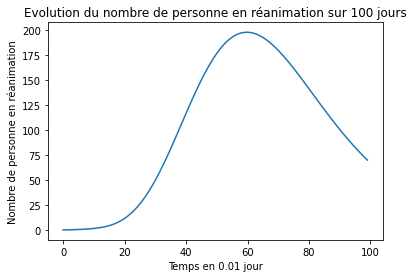

In [30]:
# Analyse des résultats

variables = init_variables()
constants = compute_constants(variables)

syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
plt.plot(simulation[::int(1/global_constants['deltaT']),6])
plt.title(f"Evolution du nombre de personne en réanimation sur {global_constants['T_MAX']} jours")
plt.xlabel(f"Temps en {global_constants['deltaT']} jour")
plt.ylabel("Nombre de personne en réanimation")



2) **Par échantillonnage Monte Carlo (en utilisant les lois des paramètres d'entrée de la table 1), donner :**
- la loi du nombre maximal de patients présents en soins intensifs (histogramme, moyenne, quantiles à 10% et 90%),
- la loi de la date du pic de l'épidémie.

In [31]:
## Implémentation de la méthode de Monte Carlo classique pour la résolution du système différentiel. 

M = 10000

def Monte_Carlo(M):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    M : int, 
        Taille de l'échantillon. 
    
    Sorties : 
    ---------
    peak_value  : list,
        Nombre de cas en réanimation au pic de l'épidémie pour chaque simulation.
    peak_day    : list, 
        Jour du pic pour chaque simulation.
    pos         : list, 
        Nombre de cas au pic de l'épidémie pour chaque simulation.
    
    """
    
    print(f"Echantillonnage de Monte Carlo sur {M} simulations")
    peak_value,peak_day, pos = [],[], []
    pbar = ProgressBar()
    for i in pbar(range(M)):
        variables = init_variables(deltaT=0.01,global_constants = global_constants)
        constants = compute_constants(variables)
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))      
        peak_value.append(np.max(simulation[:,6]))
        peak_day.append(int(np.argmax(list(simulation[:,6]))*global_constants['deltaT']))
        pos.append(np.max(simulation[:,1]))
        
    return (peak_value,peak_day,pos)

peak_value,peak_day,pos = Monte_Carlo(M)


Echantillonnage de Monte Carlo sur 10000 simulations


100% |########################################################################|


La valeur moyenne du pic est de 33138.86 et appartient à l'intervalle de confiance à 95% suivant : [31739.21,34538.51] 
 Le quantile à 10% du pic de réanimation est : 45.849598944789534
 Le quantile à 90% du pic de réanimation est : 109034.84325443533


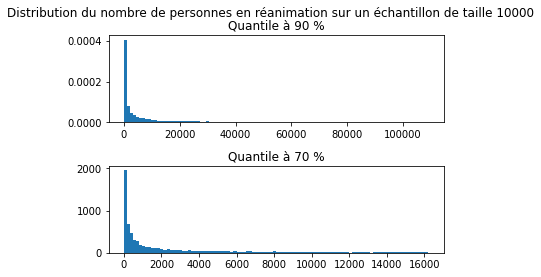

In [33]:
mean_value = np.mean(peak_value)
var_value  = np.var(peak_value)
q_10 = np.quantile(peak_value, 0.1, axis = None)
q_70 = np.quantile(peak_value, 0.7, axis = None)
q_90 = np.quantile(peak_value, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_value,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_value-1.96*np.sqrt(var_value/M),2))},{round(mean_value+1.96*np.sqrt(var_value/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 


fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du nombre de personnes en réanimation sur un échantillon de taille {M}")
axs[0].hist([value for value in peak_value if value < q_90], bins = 100, density = 1)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([value for value in peak_value if value < q_70], bins = 100)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

En supposant que la distribution du nombre de cas en réanimation au pic de l'épidémie suis une loie exponentielle, nous pouvons donner son paramètre $\lambda = \frac{1}{\mathbb{\hat{E}}(X)}$ où $X$ correspond à la variable aléatoire liée au nombre de cas en réanimation au pic de l'épidémie. Nous la notrons ici `lbd`.


0.5811767350727536


(array([1.57503958, 1.46926769, 1.43657457, 1.19041453, 1.15195203,
        0.967332  , 0.93463887, 0.96348575, 0.85771386, 0.81732823,
        0.68655572, 0.63078508, 0.60386133, 0.53655195, 0.46155006,
        0.44231881, 0.3807788 , 0.33270067, 0.30193066, 0.3653938 ,
        0.29231504, 0.24039066, 0.1826969 , 0.1980819 , 0.20000503,
        0.20000503, 0.14038814, 0.12884939, 0.11923377, 0.11154126,
        0.12308002, 0.08269439, 0.08269439, 0.07307876, 0.06923251,
        0.09423314, 0.04615501, 0.06346313, 0.06154001, 0.04807813,
        0.04615501, 0.04807813, 0.02692375, 0.05384751, 0.04230876,
        0.02692375, 0.02692375, 0.02115438, 0.02500063, 0.01730813,
        0.01923125, 0.0076925 , 0.01153875, 0.01153875, 0.02115438,
        0.0076925 , 0.0230775 , 0.01730813, 0.0076925 , 0.01346188,
        0.01346188, 0.00192313, 0.00961563, 0.00192313, 0.00192313,
        0.00192313, 0.00384625, 0.00192313, 0.00384625, 0.00384625,
        0.00576938, 0.00576938, 0.00192313, 0.00

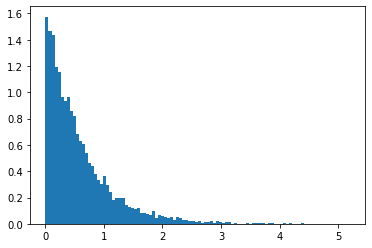

In [12]:
lbd = 1/mean_value
print(lbd)
Y = np.random.exponential(lbd,10000)
plt.hist(Y,bins = 100,density = True)

La valeur moyenne du pic est de 9.0 et appartient à l'intervalle de confiance à 95% suivant : [9.0,9.0] 
 Le quantile à 10% du pic de réanimation est : 9.0
 Le quantile à 90% du pic de réanimation est : 9.0


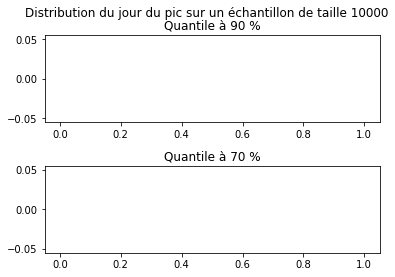

In [13]:
# Loi de la date de l'épidémie. 

mean_day = np.mean(peak_day)
var_day  = np.var(peak_day)
q_10_day = np.quantile(peak_day, 0.1, axis = None)
q_70_day = np.quantile(peak_day, 0.7, axis = None)
q_90_day = np.quantile(peak_day, 0.9, axis = None)
print(f"La valeur moyenne du pic est de {round(mean_day,2)} et appartient à l'intervalle de confiance à 95% suivant : [{max(0,round(mean_day-1.96*np.sqrt(var_day/M),2))},{round(mean_day+1.96*np.sqrt(var_day/M),2)}] ")
print(f" Le quantile à 10% du pic de réanimation est : {q_10_day}")
print(f" Le quantile à 90% du pic de réanimation est : {q_90_day}")

# Compte tenu de la valeur du quantile à 90% nous tronquons donc la liste par soucis de visibilité. 

fig, axs = plt.subplots(2)
fig.suptitle(f"Distribution du jour du pic sur un échantillon de taille {M}")
axs[0].hist([day for day in peak_day if day < q_90_day], bins = 30)
axs[0].set_title('Quantile à 90 %')
axs[1].hist([day for day in peak_day if day < q_70_day], bins = 30)
axs[1].set_title('Quantile à 70 %')
plt.subplots_adjust(hspace=0.5)

# Analyse de sensibilité qualitative : Criblage

In [14]:
def Morris(R,eps):
    """
    Echantillonage de Monte Carlo 
    
    Paramètres : 
    ------------
    
    R : int, 
        Taille de l'échantillon.
    eps : float,
        paramètre pour évaluer nos différences finies (f(x+eps)-f(x))/eps
    
    Sorties : 
    ---------
    moyenne_grad_peak_value  : array,
        Moyenne du gradient du nombre réanimation au pic de l'épidémie pour chaque simulation.
    moyenne_grad_peak_day    : array, 
        Moyenne du gradient du Jour du pic pour chaque simulation.
    sigma_grad_peak_value  : array,
        Ecart-type du gradient du nombre réanimation au pic de l'épidémie pour chaque simulation.
    sigma_Moyenne_grad_peak_day    : array, 
        Ecart-type du gradient du Jour du pic pour chaque simulation.
    
    """
    
    print(f"Calcul de sensibilité")
    grad_peak_value,grad_peak_day = [],[]
    pbar = ProgressBar()
    for i in pbar(range(R)):
        variables = init_variables()
        constants = compute_constants(variables)
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        simulation_ref=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
        peak_value_ref = np.max(simulation_ref[:,6])
        peak_day_ref = int(np.argmax(list(simulation_ref[:,6]))*global_constants['deltaT'])
        d_peak_value, d_peak_day = [], []
    
        for key, value in variables.items():
            sauvegarde = variables[key]
            variables[key] = sauvegarde +eps
            constants = compute_constants(variables)
            simulation= odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
            peak_value = np.max(simulation[:,6])
            peak_day = int(np.argmax(list(simulation[:,6]))*global_constants['deltaT'])
            d_peak_value.append((peak_value-peak_value_ref)/eps)
            d_peak_day.append((peak_day-peak_day_ref)/eps)
            variables[key] = sauvegarde
        
        grad_peak_value += [d_peak_value]
        grad_peak_day += [d_peak_day]
        
    grad_peak_value, grad_peak_day = np.abs(np.array(grad_peak_value)), np.abs(np.array(grad_peak_day))
     
    moyenne_grad_peak_value = np.mean(grad_peak_value, axis=0)
    moyenne_grad_peak_day = np.mean(grad_peak_day, axis=0)
    sigma_grad_peak_value = np.sqrt(np.var(grad_peak_value, axis=0))
    sigma_grad_peak_day = np.sqrt(np.var(grad_peak_day, axis=0))
    
    return( moyenne_grad_peak_value,  moyenne_grad_peak_day, sigma_grad_peak_value, sigma_grad_peak_day )
        

R=100
eps = 10**(-4)
moyenne_grad_peak_value,  moyenne_grad_peak_day, sigma_grad_peak_value, sigma_grad_peak_day = Morris(R, eps)

Calcul de sensibilité


KeyboardInterrupt: 

In [9]:
print(moyenne_grad_peak_value)
print(moyenne_grad_peak_day)
print(sigma_grad_peak_value)
print(sigma_grad_peak_day)

[4.19905680e+04 6.54428652e+04 5.62246061e+05 2.14991970e-01
 5.12549068e+04 2.64866143e-02 4.63938045e+04 1.26875692e+06
 7.91285798e+05 3.52350880e+03 1.76222658e+03 1.06202455e+04
 2.08075196e+02 9.26004823e+02 0.00000000e+00]
[  0.   0. 200.   0.   0.   0.   0. 600.   0.   0.   0.   0.   0.   0.
   0.]
[1.15120797e+05 2.09462609e+05 1.65119525e+06 1.55317518e+00
 1.70041629e+05 1.76690051e-01 1.13022113e+05 4.06201464e+06
 1.92083228e+06 8.82828310e+03 4.41479737e+03 2.73288989e+04
 7.42636394e+02 2.66952741e+03 0.00000000e+00]
[   0.            0.         1400.            0.            0.
    0.            0.         2374.86841741    0.            0.
    0.            0.            0.            0.            0.        ]


#### analyse des résultats : ...

## Criblage avec SALib

In [37]:
from SALib.analyze import morris
from SALib.sample import morris as sample_morris

In [38]:
problem = {
    'num_vars': 15,
    'names': ['p_a','p_IH','p_IU','p_HD','p_HU','p_UD','R_0','mu','lambda_1','t_0','N','N_I','N_H','N_U','I_moins_0'],
    'bounds': [[0.4,0.9],[0.05,0.2],[0.01,0.04],[0.1,0.2],[0.1,0.2],[0.2,0.4],[2.9,3.4],[0.01,0.08],[10**(-4),10**(-3)],[0,30],[30,50],
[8,12],[15,25],[10,20],[1,100]]
}


def Resolution(parametres):
    peak_value = np.zeros(len(parametres))
    peak_day = np.zeros(len(parametres))
    
    for i, X in enumerate(parametres):
    
        if type(X)!= dict:
            variables = dict(zip(variables_keys,X))
            #constants = dict(zip(constants_keys, constants))
        else : 
            variables = X
        constants = compute_constants(variables)   
        syst_CI=array([global_constants['S_0'],variables['I_moins_0'],0,0,0,0,0,0,0,0])
        solution=odeint(equa_diff,syst_CI,constants['t'], args = (variables,constants))
        peak_value[i]=np.max(solution[:,6])
        peak_day[i]=int(np.argmax(list(simulation[:,6]))*global_constants['deltaT'])
    return(peak_value, peak_day)



In [39]:
X = sample_morris.sample(problem, 100, num_levels=4)
peak_value, peak_day = Resolution(X)
Smorris_value = morris.analyze(problem, X, peak_value, conf_level=0.95,print_to_console=True, num_levels=4)
Smorris_day = morris.analyze(problem, X2, peak_day, conf_level=0.95,print_to_console=True, num_levels=4)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
p_a                             59673.485 -59673.485       21012.742 116058.173
p_IH                            11420.656  11420.656        4715.032  28455.496
p_IU                            21361.295  21361.295        9051.091  49733.630
p_HD                                0.000      0.000           0.000      0.002
p_HU                             8538.400   8538.400        5344.272  27057.314
p_UD                                0.000      0.000           0.000      0.001
R_0                             23782.282  23782.282       11258.930  56569.593
mu                              49810.551 -49810.551       22674.422 110893.147
lambda_1                          909.838    909.838         378.715   2235.118
t_0                             86275.465 -86275.465       34286.981 182527.360
N                               43498.420  43498.420       18139.615  93789.235
N_I                             40820.16

# Analyse de sensibilité quantitative : Sobol

In [32]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
from pylab import *
from scipy.integrate import odeint

In [34]:
param_values = saltelli.sample(problem, 100, calc_second_order=True)
peak_value, peak_day = Resolution(param_values)
Si_peak_value = sobol.analyze(problem, peak_value, print_to_console=True)
Si_peak_day = sobol.analyze(problem, peak_day, print_to_console=True)

Group S1 S1_conf ST ST_conf
p_a -0.000146 0.020678 0.037221 0.065862
p_IH -0.002007 0.005740 0.002609 0.004675
p_IU -0.003144 0.015213 0.018217 0.035263
p_HD -0.000000 0.000000 0.000000 0.000000
p_HU 0.000338 0.008289 0.005514 0.012261
p_UD 0.000000 0.000000 0.000000 0.000000
R_0 -0.013241 0.036366 0.056631 0.106677
mu 0.033912 0.147302 0.249991 0.440106
lambda_1 0.000033 0.000739 0.000046 0.000096
t_0 0.132375 0.135238 0.187887 0.300740
N 0.060586 0.123713 0.147749 0.295053
N_I 0.002764 0.031315 0.073431 0.143127
N_H 0.000368 0.002150 0.000425 0.000980
N_U 0.003004 0.007093 0.002511 0.004568
I_moins_0 0.001311 0.014525 0.011436 0.028778

Group_1 Group_2 S2 S2_conf
p_a p_IH 0.006083 0.032374
p_a p_IU 0.005729 0.032162
p_a p_HD 0.005829 0.033045
p_a p_HU 0.005058 0.034163
p_a p_UD 0.005829 0.033045
p_a R_0 0.006293 0.032547
p_a mu -0.008589 0.051503
p_a lambda_1 0.005835 0.033003
p_a t_0 -0.005270 0.030789
p_a N -0.003412 0.045203
p_a N_I 0.004408 0.034762
p_a N_H 0.005837 0.033007
p_a 

# Calibration

In [15]:
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import ticker

In [16]:

contamination = pd.read_csv('data_per_day.csv', sep = ';')
contamination.columns = [jour,'detecte']
contamination[jour] = pd.to_datetime(contamination[jour],infer_datetime_format = True)
contamination = contamination[contamination[jour]<= '2020-05-11']
contamination['detecte'] = contamination['detecte'].diff(periods = 1)

 
hosp          = pd.read_csv('donnees_hospitalieres.csv', ';')
hosp[jour]    = pd.to_datetime(hosp[jour])
hosp          = hosp.groupby(jour).agg('sum').reset_index(False)[[jour,'hosp','rea','rad','dc']]
big_table     = hosp.merge(contamination, left_on= jour, right_on = jour)
big_table     = big_table[big_table[jour]<= '2020-05-11']
big_table.head()   

,jour,hosp,rea,rad,dc,detecte
0,2020-03-18,5905,1535,1627,435,1404.0
1,2020-03-19,7961,1975,2322,642,1861.0
2,2020-03-20,10272,2564,3128,890,1617.0
3,2020-03-21,11599,2872,3580,1041,1847.0
4,2020-03-22,13675,3311,4188,1251,1559.0


Text(0.5, 1.0, 'Spread of the epidemic')

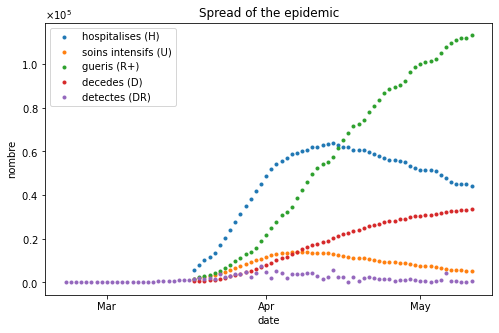

In [17]:
columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

# Calibration déterministe

Pour répondre à cette question, nous lançons la fonction `minimize` de scipy.optimize 100 fois et nous gardons uniquement le 15-uplets de valeurs qui minimise le plus fortement la fonction objectif.

Une telle démarche a nécessairement un coût de calcul assez fort et nous sauvons donc le tout dans un excel fournit avec le jupyter. Afin de pouvoir générer les variables veuillez mettre `generate_variables` à la valeur `True`. Autrement, les variables seront importées depuis le fichier CSV en question. 

In [22]:
from scipy.optimize import minimize
generate_variables = False

In [19]:
# Table pre-processing
contamination = contamination[('2020-02-25' <= contamination[jour])& (contamination[jour]<= '2020-03-31')]
big_table     = big_table[big_table[jour]<= '2020-03-31']
sigmas        = [1,1,1,1,1]
print(global_constants['deltaT'])

0.01


In [20]:

def Epsilon(variables,constants,contamination = contamination,big_table=big_table,global_constants=global_constants, sigmas = sigmas,n_DR=n_DR,n_H=n_H):
    """
    parameters will be a dictionnary similar to the one resulting from init_constant    
    """
    
    syst_CI=array([global_constants['S_0'],variables[-1],0,0,0,0,0,0,0,0])
    simulation=odeint(equa_diff,syst_CI,constants[-2],args = (variables,constants))[::int(1/global_constants['deltaT'])]
    
    DR = ((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1])/sigmas[0])**2
    
    H  = ((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5])/sigmas[1])**2
    U  = ((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6])/sigmas[2])**2
    D  = ((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8])/sigmas[3])**2
    R  = ((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7])/sigmas[4])**2
    return np.sum(DR) + np.sum(H+U+D+R)



In [21]:


def q_7_function():
    """
    This function compute the minimization routine one time and return the 15-uplet and the value of the objectiv function.    
    """
    variables = init_variables(T_MAX = 66)
    constants = compute_constants(variables, global_constants = global_constants)
    variables = list(variables.values())
    constants = list(constants.values())

    res = minimize(Epsilon,x0 = variables,bounds = bound, args = (constants))
    optimal_variables = dict(zip(variables_keys,res.x))
    return optimal_variables,res.fun

if generate_variables :     
    all_results = []
    all_variables = []
    pbar = ProgressBar()

    for i in pbar(range(100)):
        optimal_variables, res = q_7_function()
        all_results.append(res)
        all_variables.append(optimal_variables)
    
    best_variables = all_variables[np.argmin(all_results)]
    with open('best_variables_q7.csv', 'w') as f:
        f.write("%s,%s\n"%('variables','values'))
        for key in best_variables.keys():
            f.write("%s,%s\n"%(key,best_variables[key]))
    
    
else : 
    best_variables = pd.read_csv('best_variables_q7.csv', ',')
    best_variables = best_variables['values'].to_numpy()
    best_variables = dict(zip(variables_keys,best_variables))
    

100% |########################################################################|


In [23]:

constants  = compute_constants(best_variables)
syst_CI    = array([global_constants['S_0'],best_variables['I_moins_0'],0,0,0,0,0,0,0,0])
simulation = odeint(equa_diff,syst_CI,constants['t'], args = (best_variables,constants))[::10]

660


Text(0.5, 1.0, 'Spread of the epidemic')

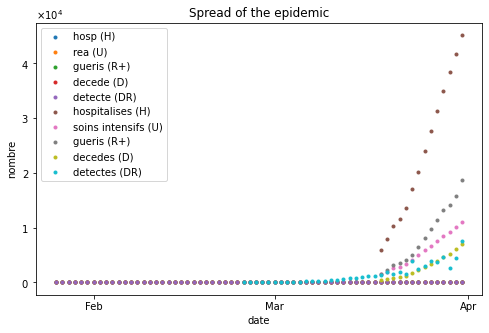

In [25]:
fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
columns  = [5,6,7,8,9]
titles   = {'5':'hosp (H)','6': 'rea (U)','8':'decede (D)', '9':'detecte (DR)','7': 'gueris (R+)'}
time     = pd.date_range(start =  '2020-01-26', end = '2020-03-31', freq = 'D')

print(len(simulation))
for i,col in enumerate(columns) : 
    axs.scatter(time,simulation[:66,col],marker = '.', label = titles[f"{col}"])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')



columns = ['hosp','rea','rad','dc']
titles  = {'hosp': 'hospitalises (H)', 'rea': 'soins intensifs (U)', 'dc' : 'decedes (D)', 'detecte' : 'detectes (DR)', 'rad' : 'gueris (R+)'}

fig, axs = plt.subplots(figsize = (8,5), nrows = 1, ncols = 1)
for i,col in enumerate(columns) : 
    axs.scatter(big_table[jour],big_table[col],marker = '.', label = titles[col])
axs.scatter(contamination[jour],contamination['detecte'], marker = '.', label = titles['detecte'])
axs.legend()
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)


formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1))
axs.yaxis.set_major_formatter(formatter) 
axs.set_ylabel('nombre')
axs.set_xlabel('date')
axs.format_xdata = mdates.DateFormatter('%Y-%m-%d')
axs.set_title('Spread of the epidemic')

8) **Donnez les valeurs de $\sigma_C$ pour $C$ dans $\{H,U,D,R\}$**

L'énoncé nous dit que : 

$\begin{equation}
p(data|x,\sigma)=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{DR}^{-n_{DR}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times e^{-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}
\end{equation}$

Que l'on peut réécrire de la manière suivante afin de d'utiliser une optimisation sous log-vraisemblance par la suite : 

$\begin{equation}
p(data|x,\sigma)=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times e^{-n_{DR}ln(\sigma_{DR})-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}
\end{equation}$


On atteint un optimum pour l'expression suivante quand toutes les compostantes du gradient sont nulles. En raisonnant pour $\sigma_{DR}$ on a : 

$\begin{align}
\frac{\partial}{\sigma_{DR}}p(data|x,\sigma)&=(2\pi)^{-\frac{n_{DR}}{2}-2n_{H}}\sigma_{H}^{-n_{H}}\sigma_{U}^{-n_{H}}\sigma_{D}^{-n_{H}}\sigma_{R}^{-n_{H}}\times(-\frac{n_{DR}}{\sigma_{DR}}+\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{3}})e^{-n_{DR}ln(\sigma_{DR})-\frac{1}{2}\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{2}}-\frac{1}{2}\sum_{i=1}^{n_{H}}\frac{f_{H}(x,s_{i})2}{\sigma_{H}^{2}}+\frac{f_{U}(x,s_{i})^{2}}{\sigma_{U}^{2}}+\frac{f_{D}(x,s_{i})^{2}}{\sigma_{D}^{2}}+\frac{f_{R}(x,s_{i})^{2}}{\sigma_{R}^{2}}}\\
&=0
\end{align}$
Ce qui revient à écrire que : 


$\begin{align}
& \ \frac{n_{DR}}{\sigma_{DR}}=\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{\sigma_{DR}^{3}}\\
\Leftrightarrow &  \ \sigma_{DR}^{2}=\sum_{i=1}^{n_{DR}}\frac{f_{DR}(x,s_{i})^{2}}{n_{DR}}
\end{align}$

En raisonnant de même pour les autres sigmas, il vient que :

$\sigma_{C}^{2}=\sum_{i=1}^{n_{H}}\frac{f_{C}(x,s_{i})^{2}}{n_{H}}$



9) **Donner une expression implicite de la loi a posteriori $p(x|data)$ des paramètres x.**

Le théorème de Bayes nous donne que : $p(x|data) \propto p(data|x)p_0(x)$.

Pour l'approche plug-in, on fixe les valeurs de sigma tel que définis à la question 8. Dans ce cas, on a : 

$\begin{equation}
p(x|data)=p(data|x)p_0(x)
\end{equation}$

Dans le cadre de l'approche full-bayésienne comme on a : $\pi(\sigma_C)=(\sigma_C)^{-1}$ pour $C$ dans $\{H,U,D,R\}$ alors on peut écrire que : $\begin{align}
p(x|data) &\propto \int_{\sigma}p(x,\sigma|data)d\sigma\\
&\propto \int_{\sigma}p(data|x,\sigma)p(\sigma)p_0(x)d\sigma
\end{align}$

En utilisant les expressions de chacun des $\sigma$ on peut développer l'intégrale et donner une expression implicite de cette densité. 


10) **Dans le cas plug-in, puis dans le cas full-bayésien, comparer les lois a priori et a posteriori uni-dimensionnelles de chacun des paramètres (histogramme,moyenne, variance). Estimer la matrice de corrélation a posteriori des paramètres. Quels sont les paramètres pour lesquels l'incertitude a été fortement réduite ou au contraire très peu réduite ?**


Nous connaissons les lois à postériori à une constante multiplicative près. De ce fait nous souhaitons donc simuler la distribution de $p(x|data)$ en utilisant un algorithme de Metropolis Hasting. 

A partir d'un point $X_0$, nous construisons la chaîne de Markov de la façon suivante : 

- On propose un déplacement vers $\tilde{X}_{n+1}$ selon la loi $q(X_n,\sigma^2I)$ supposée gaussienne. On améliorera la matrice de covariance de cette loi durant la procédure de burn-in. 

- On accepte le déplacement avec la probabilité $a(X_n,\tilde{X}_{n+1})$. La fonction $a$ est définie comme suit : 

\begin{align}
a(X_n,\tilde{X}_{n+1}) &= min\{\frac{p(\tilde{X}_{n+1}|data)Q(X_n,\tilde{X}_{n+1})}{p(X_n|data)Q(\tilde{X}_{n+1},X_n)},1\}\\
&= min\{\frac{p(data|\tilde{X}_{n+1})Q(X_n,\tilde{X}_{n+1})}{p(data|X_n)Q(\tilde{X}_{n+1},X_n)},1\}
\end{align}



In [110]:



F = {'p_a': 'norm',
    'p_IH': 'norm',
    'p_IU': 'norm',
    'p_HD': 'norm',
    'p_HU': 'norm',
    'p_UD': 'norm',
    'N_I' : 'norm',
    'N_H' : 'norm',
    'N_U' : 'norm',
    'R_0' : 'norm',
    'mu'  : 'norm',
    'N'   : 'norm',
    't_0'   : 'norm',
    'I_moins_0' : 'norm',
    'lambda_1' : 'norm'
}



F_parameters = {'p_a': {'loc':0.65,'scale':0.1},
    'p_IH': {'loc':0.125,'scale':0.1},
    'p_IU': {'loc':0.025,'scale':0.1},
    'p_HD': {'loc':0.15,'scale':0.1},
    'p_HU': {'loc':0.15,'scale':0.1},
    'p_UD': {'loc':0.3,'scale':0.1},
    'N_I' : {'loc':10,'scale':1},
    'N_H' : {'loc':20,'scale':1},
    'N_U' : {'loc':15,'scale':1},
    'R_0' : {'loc':3.15,'scale':0.1},
    'mu'  : {'loc':0.05,'scale':0.01},
    'N'   : {'loc':40,'scale':1},
    't_0' : {'loc':15, 'scale':1},
    'I_moins_0' : {'loc':50,'scale':1},
    'lambda_1' : {'loc':0.5*10**(-4),'scale':10**(-5)}
}


print(F_parameters)


{'p_a': {'loc': 0.65, 'scale': 0.1}, 'p_IH': {'loc': 0.125, 'scale': 0.1}, 'p_IU': {'loc': 0.025, 'scale': 0.1}, 'p_HD': {'loc': 0.15, 'scale': 0.1}, 'p_HU': {'loc': 0.15, 'scale': 0.1}, 'p_UD': {'loc': 0.3, 'scale': 0.1}, 'N_I': {'loc': 10, 'scale': 1}, 'N_H': {'loc': 20, 'scale': 1}, 'N_U': {'loc': 15, 'scale': 1}, 'R_0': {'loc': 3.15, 'scale': 0.1}, 'mu': {'loc': 0.05, 'scale': 0.01}, 'N': {'loc': 40, 'scale': 1}, 't_0': {'loc': 15, 'scale': 1}, 'I_moins_0': {'loc': 50, 'scale': 1}, 'lambda_1': {'loc': 5e-05, 'scale': 1e-05}}


In [167]:
from scipy.stats import lognorm
from scipy.stats import norm
from scipy.stats import uniform
np.random.seed(4)
def not_accepted_move(X_):
    
    variables = dict(zip(variables_keys,X_))
    for key,value in variables.items():
        if key in ['p_a','p_IH','p_IU','p_HD','p_HU','p_UD'] and not 0<=value<=1 :
            print(key,'first')
            return True 
        if key in ['N_I','N_H','N_U','R_0','mu','N','t_0','I_moins_0','lambda_1'] and value < 0 :
            print(key,'second')
            return True
        if key == 'I_moins_0' and value < 1 : 
            print(key,'third')
            print(value)
            return True
    
    return False
        
    

def move(X,F_current_parameters):
    """
    Generate a possible movement for our scale
    """
    variables = dict(zip(variables_keys,X))
    X_ = []
    for key,values in variables.items() :
        f = F[key]
        if f == 'lognorm':
            x_ = lognorm.rvs(s = F_current_parameters[key]['s'], scale = values)
        if f == 'norm'   : 
            x_ = norm.rvs(loc = values, scale = F_current_parameters[key]['scale'] )
        if f == 'uniform' : 
            
            if F_parameters[key]['constraint']=='one':
                if values-F_current_parameters[key]['scale']/2 < F_parameters[key]['low'] :
                    F_current_parameters[key]['scale'] = 2*(values-F_parameters[key]['low'])
                    
            if F_parameters[key]['constraint']=='two':
                if values-F_current_parameters[key]['scale']/2 < F_parameters[key]['low'] or values+F_current_parameters[key]['scale']/2 > F_parameters[key]['high']:
                    F_current_parameters[key]['scale'] = min(2*(values-F_parameters[key]['low']),2*(F_parameters[key]['high']-values))
                    print('two',min(2*(values-F_parameters[key]['low']),2*(F_parameters[key]['high']-values)))
            x_ = uniform.rvs(loc = values - F_current_parameters[key]['scale']/2, scale = F_current_parameters[key]['scale'])
            
        if f == 'beta' :
            x_ = beta.rvs(loc = F_current_parameters[key]['loc'], scale = F_current_parameters[key]['scale'], a = 5, b = 5)
        X_.append(x_)
    return X_


def Q(X,X_):
    """
    Give the propability of the transition
    """
    probs = []
    
    variables  = dict(zip(variables_keys,X))
    variables_ = dict(zip(variables_keys,X_))  
    for key in variables_keys : 
        f = F[key]
        if f == 'lognorm':
            prob = lognorm.pdf(variables[key], s = variables_[key], scale = F_current_parameters[key]['scale'])
        if f == 'norm'   : 
            prob = norm.pdf(variables[key], loc = variables_[key], scale = F_current_parameters[key]['scale'])
        if f == 'uniform':
            prob = uniform.pdf(variables[key], loc = variables_[key] - F_current_parameters[key]['scale']/2 ,scale = F_current_parameters[key]['scale'] )
        if f == 'beta' : 
            prob = beta.pdf(variables[key], loc = variables_[key], scale = F_current_parameters[key]['scale'], a = 5 , b = 5)
        
        probs.append(prob)

        
    probs = np.array(probs)
    
    return np.prod(probs)

def a_plug_in(X,X_,sigmas):
    """
    Given a former position X and a new position X_, return the new position
    """
    if not_accepted_move(X_):
        print('rejected')
        return 0
    ratio = plug_in(X_,sigmas)*Q(X,X_)/(plug_in(X,sigmas)*Q(X_,X))
    minimum = min(ratio,1)
   
    U     = np.random.uniform()
    if U> minimum : 
        return 0
    else :
        return 1
    
def Metropolis_Hasting_plug_in(X,F_parameters,n= 100000):
    """
    Given a random point X, we return a sample of Metroplis Hasting of size n. 
    """
    
    X = (list(X.values()))
    chain = [X]
    
    burn_in = n//10
    burn_in_period = burn_in//100
    
    acceptation_history = np.zeros(burn_in_period)
    sigmas = compute_sigmas()
    pbar   = ProgressBar()
    for i in pbar(range(n)):
        X  = chain[-1]
        X_ = move(X,F_parameters)
        test = a_plug_in(X,X_,sigmas)
        if test == 1 :             
            chain.append(X_)
        acceptation_history[i%burn_in_period] = test
        
        if i % burn_in_period == 0 and 1< i < burn_in :
            rate = np.mean(acceptation_history)
            if rate < 0.25 : 
                update_F('down')
                print('down',rate)
            if rate > 0.50 : 
                update_F('up')
                print('up',rate)
            acceptation_history = np.zeros(burn_in_period)
        if i == burn_in :
            break
    for X in chain : 
        print(dict(zip(variables_keys,X)))
    
    return 'youpi'

def update_F(variation,F = F, F_parameters = F_parameters):
    
    for key in F_parameters.keys() : 
        if F[key] == 'lognormal':
            if variation == 'up' : 
                F_parameters[key]['s']*= 1.1
            if variation == 'down' :
                F_parameters[key]['s']*= 0.9
        if F[key] == 'norm':
            if variation == 'up':
                F_parameters[key]['scale']*= 1.1
            if variation == 'down':
                F_parameters[key]['scale']*= 0.9
        if F[key] == 'uniform':
            if variation == 'up':
                F_parameters[key]['scale']*= 1.1
            if variation == 'down':
                F_parameters[key]['scale']*= 0.9
        if F[key] == 'beta':
            if variation == 'up':
                F_parameters[key]['scale']*= 1.1
            if variation == 'down':
                F_parameters[key]['scale']*= 0.9
        
            
    

def plug_in(X,sigmas):
    
    """
    Given the set of best variables, return the plug in probability according to the data.
    """
    variables = dict(zip(variables_keys,X))
    constants = compute_constants(variables)
   
    constants = list(constants.values())
    result =  np.log((2*np.pi))*(-n_DR/2-2*n_H)+np.log(sigmas[0])*(-n_DR)+np.log((np.prod(sigmas[1:])))*(-n_H)+(-0.5*Epsilon(X,constants,sigmas = sigmas))
    
    return np.exp(result)

def compute_sigmas(best_variables = best_variables,n_DR=n_DR,n_H=n_H,contamination = contamination,big_table=big_table):
    
    constants  = compute_constants(best_variables)
    syst_CI    = array([global_constants['S_0'],best_variables['I_moins_0'],0,0,0,0,0,0,0,0])
    simulation = odeint(equa_diff,syst_CI,constants['t'], args = (best_variables,constants))[::10]
    
    sigma_DR = np.sqrt(np.mean(((simulation[n_DR:,-1]-contamination['detecte'].to_numpy())/np.sqrt(simulation[n_DR:,-1]))**2))
    
    sigma_H  = np.sqrt(np.mean(((simulation[n_H:,5]-big_table['hosp'].to_numpy())/np.sqrt(simulation[n_H:,5]))**2))
    sigma_U  = np.sqrt(np.mean(((simulation[n_H:,6]-big_table['rea'].to_numpy())/np.sqrt(simulation[n_H:,6]))**2))
    sigma_D  = np.sqrt(np.mean(((simulation[n_H:,8]-big_table['dc'].to_numpy())/np.sqrt(simulation[n_H:,8]))**2))
    sigma_R  = np.sqrt(np.mean(((simulation[n_H:,7]-big_table['rad'].to_numpy())/np.sqrt(simulation[n_H:,7]))**2))
    
    sigmas = [sigma_DR,sigma_H,sigma_U,sigma_D,sigma_R]
    return sigmas

variables = init_variables(T_MAX = 66)

Metropolis_Hasting_plug_in(variables, F_parameters)
    

<ipython-input-167-0aad98349ef2>:87: RuntimeWarning: invalid value encountered in double_scalars
  ratio = plug_in(X_,sigmas)*Q(X,X_)/(plug_in(X,sigmas)*Q(X_,X))


p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
up 0.92
p_IU first
rejected
p_IU first
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
p_IU first
rejected
p_IU first
rejected
mu second
rejected
up 0.91
mu second
rejected
mu second
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
p_IU first
rejected
up 0.9
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
up 0.9
p_IU first
rejected
p_IU first
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejected
mu second
rejecte

KeyboardInterrupt: 

In [ ]:
from scipy.stats import lognorm
from scipy.stats import uniform
from scipy.stats import beta

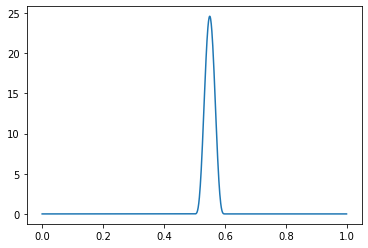

In [91]:
X = np.arange(0,1,0.001)
Y = beta.pdf(X,loc = 0.5 ,scale = 0.1, a = 5, b = 5)
plt.plot(X,Y)

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'int'

In [92]:
lognorm == lognorm

True